In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from function_utils import display_circles
import gc

In [2]:
sns.set_palette("Pastel2")

In [3]:
df = pd.read_csv("datasets/data_segmentation_rfm.csv")
df.set_index("customer_id", inplace=True)
df.head(3)

,Recency,Frequency,MonetaryValue
customer_id,,,
00012a2ce6f8dcda20d059ce98491703,338,1,114.74
000161a058600d5901f007fab4c27140,459,1,67.41
0001fd6190edaaf884bcaf3d49edf079,597,1,195.42


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96095 entries, 00012a2ce6f8dcda20d059ce98491703 to ffffe8b65bbe3087b653a978c870db99
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        96095 non-null  int64  
 1   Frequency      96095 non-null  int64  
 2   MonetaryValue  96095 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.9+ MB


# Préparation des données

In [5]:
customers = pd.DataFrame()
customers["Recency"] = np.log1p(df['Recency'])
customers["Frequency"] = np.log1p(df["Frequency"])
customers["MonetaryValue"] =np.log1p(df["MonetaryValue"])
customers.tail()

,Recency,Frequency,MonetaryValue
customer_id,,,
fffecc9f79fd8c764f843e9951b11341,5.318120,1.386294,3.336481
fffeda5b6d849fbd39689bb92087f431,5.010635,0.693147,4.160912
ffff42319e9b2d713724ae527742af25,4.852030,0.693147,5.371242
ffffa3172527f765de70084a7e53aae8,6.021023,0.693147,3.839452
ffffe8b65bbe3087b653a978c870db99,5.953243,0.693147,2.963725


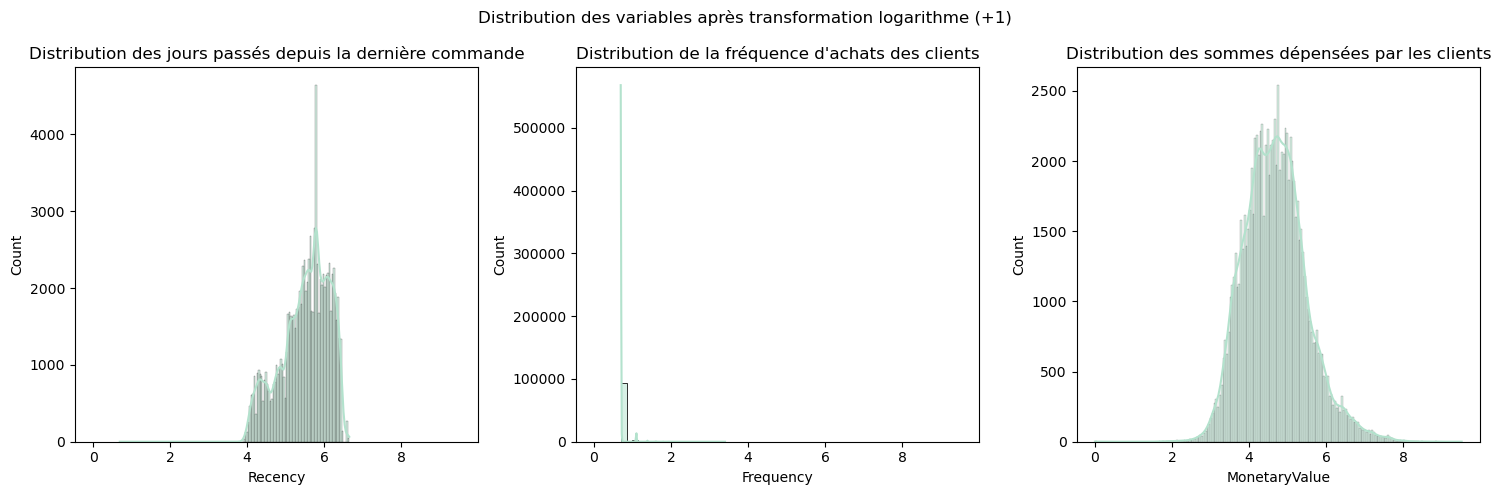

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True)
fig.suptitle('Distribution des variables après transformation logarithme (+1)')

sns.histplot(ax=axes[0],x="Recency", data=customers, kde=True)
axes[0].set_title("Distribution des jours passés depuis la dernière commande")

sns.histplot(ax=axes[1],x="Frequency", data=customers, kde=True)
axes[1].set_title("Distribution de la fréquence d'achats des clients")

sns.histplot(ax=axes[2],x="MonetaryValue", data=customers, kde=True)
axes[2].set_title("Distribution des sommes dépensées par les clients")

plt.tight_layout()
plt.show();

- Standardisation

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(customers)
customers_normalized = scaler.transform(customers)

print("Mean:", customers_normalized.mean(axis=0).round(2))
print("Standard Deviation:", customers_normalized.std(axis=0).round(2))

Mean: [0. 0. 0.]
Standard Deviation: [1. 1. 1.]


# Réduction de dimensions

In [8]:
from sklearn.decomposition import PCA

n_comp = 2
pca = PCA(n_components = n_comp)
features = customers.columns
data_pca = pca.fit_transform(customers_normalized)
pcs = pca.components_

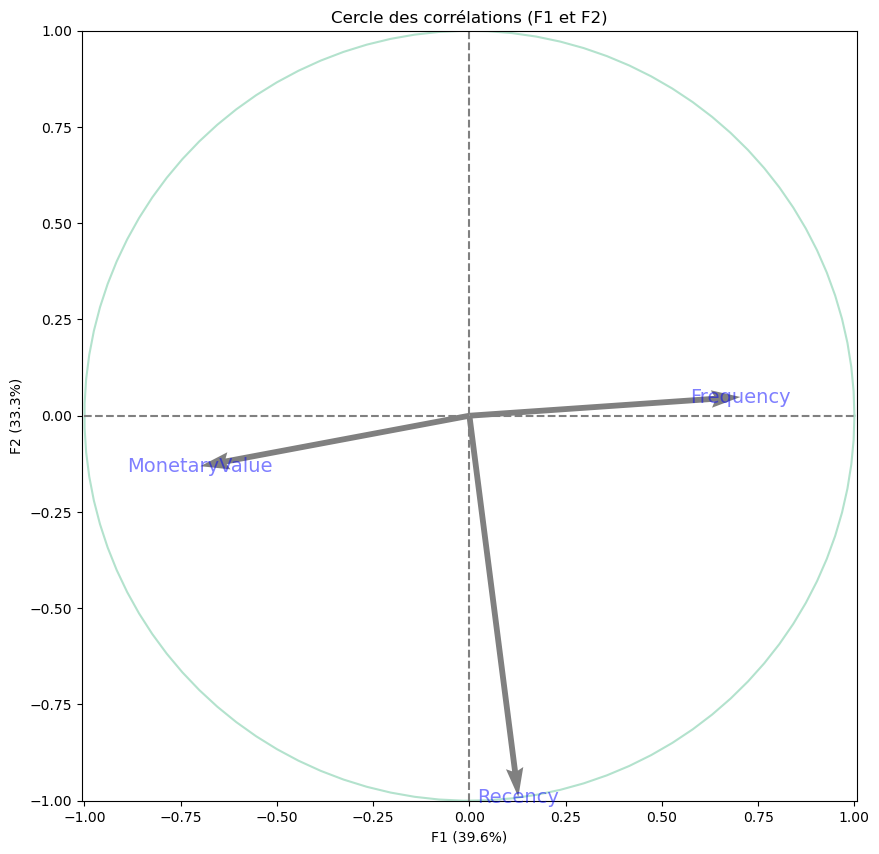

In [9]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Modélisation

## K-Means

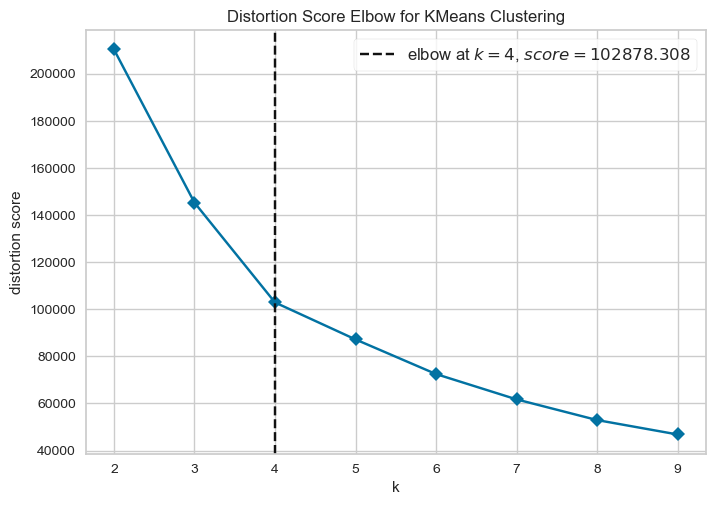

In [10]:
# Elbow method pour déterminer le nombre de clusters optimale
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k =(2, 10), timings=False)
visualizer.fit(customers_normalized)
visualizer.show();

In [11]:
sns.set_palette("Pastel2")

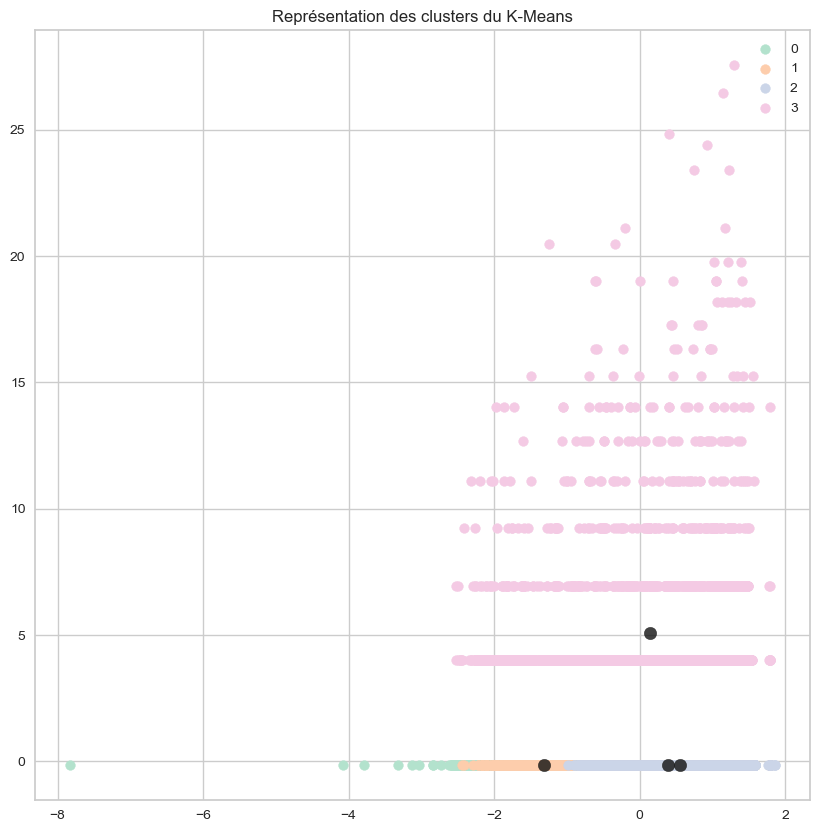

In [12]:
# Calcul du K-Means et affectation du cluster à chaque bâtiment
km = KMeans(n_clusters=4)

#Prédiction
label = km.fit_predict(customers_normalized)
 
centroids = km.cluster_centers_
u_labels = np.unique(label)

#Représentation graphique:
plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(customers_normalized[label == i , 0] , customers_normalized[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
#plt.savefig("Présentation/Images/representation_kmeans.png")
plt.show();

### Description des clusters obtenus avec le modèle

In [13]:
df["Cluster"] = km.labels_
df.groupby('Cluster').agg({
    'Recency' : "mean", 
    'Frequency' : "mean",
    'MonetaryValue': ["mean", "count"]}).round(2)

Recency Frequency MonetaryValue       
           mean      mean          mean  count
Cluster                                       
0        116.01       1.0        124.25  25239
1        337.28       1.0        316.97  29025
2        366.09       1.0         68.99  38993
3        311.95       2.5         76.86   2838

In [14]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = df.index
df_normalized["Cluster"] = km.labels_

df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=["ID", "Cluster"],
                      value_vars = ["Recency", "Frequency", "MonetaryValue"],
                      var_name = "Attribute",
                      value_name = "Value")

df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,00012a2ce6f8dcda20d059ce98491703,2,Recency,0.517454
1,000161a058600d5901f007fab4c27140,2,Recency,1.013464
2,0001fd6190edaaf884bcaf3d49edf079,1,Recency,1.439821
3,0002414f95344307404f0ace7a26f1d5,1,Recency,0.900084
4,000379cdec625522490c315e70c7a9fb,0,Recency,-0.340061


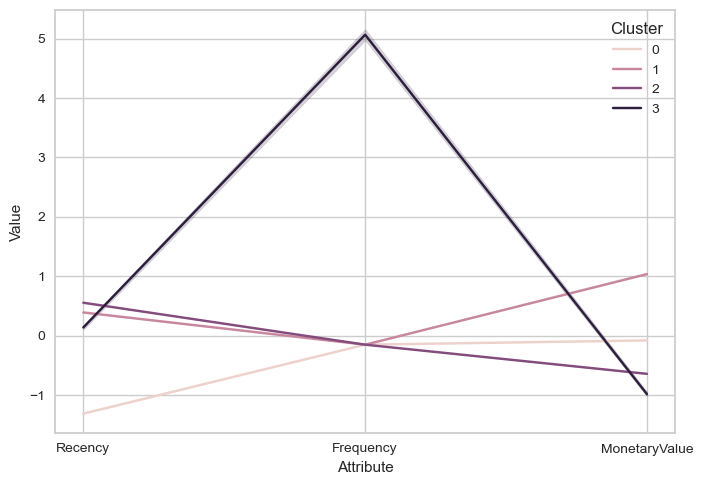

In [15]:
sns.lineplot("Attribute", "Value", hue="Cluster", data=df_nor_melt)
plt.show()

### Evaluation du modèle

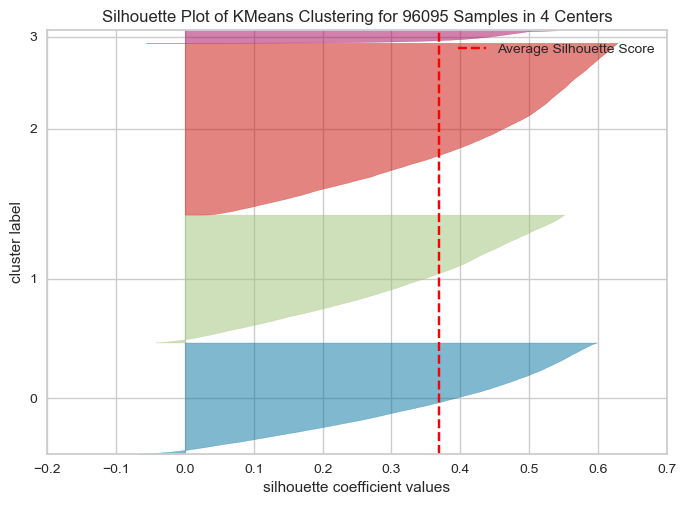

In [16]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')

visualizer.fit(customers_normalized)        # Fit the data to the visualizer
visualizer.show();              # Finalize and render the figure

In [17]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

print("Silhouette Score:", silhouette_score(customers_normalized, label))
print("Score de Davies-Bouldin:", davies_bouldin_score(customers_normalized, label))

Silhouette Score: 0.3693314528689256
Score de Davies-Bouldin: 0.8215216627674071


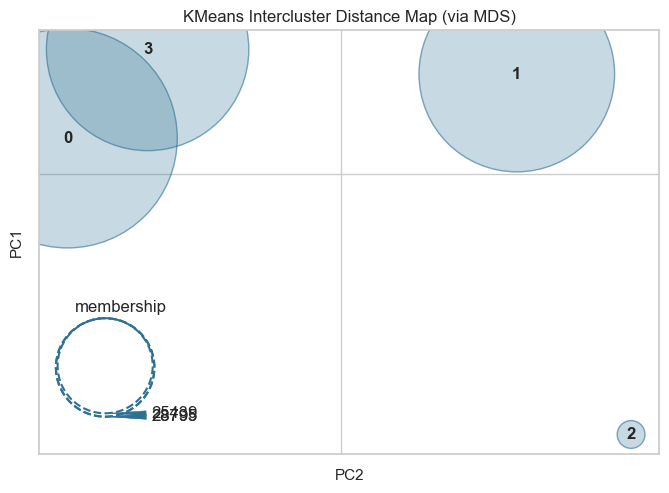

In [18]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4, random_state=42), customers_normalized);

- Diagramme de Sankey pour évaluer les flux (mensuels, bi-mensuels, trimestres)

## K-Prototype

https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical-and-numerical-fe7c50538ebb

In [19]:
from kmodes.kprototypes import KPrototypes

In [20]:
data = pd.read_csv("datasets/data_clustering_complete.csv")
data.set_index("customer_id", inplace=True)
data.head()

,customer_city,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,Recency,Frequency,MonetaryValue,distance_customer_seller
customer_id,,,,,,,,
00012a2ce6f8dcda20d059ce98491703,osasco,13.0,19.0,1.0,338.0,1.0,114.74,120.729003
000161a058600d5901f007fab4c27140,itapecerica,9.0,18.0,4.0,459.0,1.0,67.41,131.914211
0001fd6190edaaf884bcaf3d49edf079,nova venecia,5.0,21.0,5.0,597.0,1.0,195.42,550.186581
0002414f95344307404f0ace7a26f1d5,mendonca,27.0,27.0,5.0,428.0,1.0,179.35,833.351114
000379cdec625522490c315e70c7a9fb,sao paulo,9.0,13.0,4.0,199.0,1.0,107.01,310.294744


In [21]:
num_var = ["nb_days_before_delivered", "nb_days_before_delivered_estimation", "review_score", "Recency", "MonetaryValue", "distance_customer_seller"]

scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data[num_var]), columns=num_var, index=data.index)
data_normalized["customer_city"] = data["customer_city"]
data_normalized.head()

,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,Recency,MonetaryValue,distance_customer_seller,customer_city
customer_id,,,,,,,
00012a2ce6f8dcda20d059ce98491703,0.137016,-0.444731,-2.420346,0.324525,-0.193157,-0.806546,osasco
000161a058600d5901f007fab4c27140,-0.280924,-0.558915,-0.107260,1.117641,-0.411550,-0.787877,itapecerica
0001fd6190edaaf884bcaf3d49edf079,-0.698865,-0.216362,0.663769,2.022187,0.179123,-0.089727,nova venecia
0002414f95344307404f0ace7a26f1d5,1.599808,0.468743,0.663769,0.914446,0.104972,0.382910,mendonca
000379cdec625522490c315e70c7a9fb,-0.280924,-1.129836,-0.107260,-0.586576,-0.228825,-0.490137,sao paulo


In [22]:
catColumnsPos = [data_normalized.columns.get_loc(col) for col in list(data_normalized.select_dtypes('object').columns)]
print('Categorical columns           : {}'.format(list(data_normalized.select_dtypes('object').columns)))
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns           : ['customer_city']
Categorical columns position  : [6]


In [23]:
dfMatrix = data_normalized.to_numpy()
dfMatrix

array([[0.1370161845440572, -0.44473059795722625, -2.420345518045987,
        ..., -0.1931566611763058, -0.8065461886579386, 'osasco'],
       [-0.2809242982286769, -0.5589148482844968, -0.10725990901888154,
        ..., -0.4115502386069655, -0.7878766632320177, 'itapecerica'],
       [-0.698864781001411, -0.21636209730268527, 0.6637686273234871,
        ..., 0.179122946410967, -0.08972721094313206, 'nova venecia'],
       ...,
       [0.5549566673167914, 1.6105859079336426, -0.10725990901888154,
        ..., -0.4312993303332115, -0.41554499751864266, 'rio de janeiro'],
       [-0.698864781001411, -1.3582046005753903, 0.6637686273234871, ...,
        0.26545600860677604, -0.7834305871656323, 'taboao da serra'],
       [0.03253106385087366, 0.01200640335185574, 0.6637686273234871,
        ..., -0.5126489768597808, -0.7309115696038277, 'alfenas']],
      dtype=object)

In [24]:
kprototype = KPrototypes(n_jobs = -1, n_clusters = 4, init = 'Huang', random_state = 42)
kprototype.fit_predict(dfMatrix, categorical = catColumnsPos)

array([0, 2, 2, ..., 1, 3, 2], dtype=uint16)

In [25]:
kprototype.cluster_centroids_

array([['0.9535376665285847', '0.11930372171023453',
        '-2.0609542266537395', '-0.0239993242372525',
        '0.05999046424733207', '0.03440845572584645', 'sao paulo'],
       ['0.5782510710353778', '1.1198207797485433',
        '0.25308784476833135', '-0.06411721514352352',
        '0.4068753532933426', '1.5132238878140607', 'rio de janeiro'],
       ['-0.1767894352320365', '0.009323057684787717',
        '0.35071370390735174', '0.9348816733099243',
        '-0.11120327102148167', '-0.2739480024062385', 'sao paulo'],
       ['-0.48216929482095366', '-0.5798532889384157',
        '0.36368326710744336', '-0.778729443163059',
        '-0.11678962844503485', '-0.4842541099055966', 'sao paulo']],
      dtype='<U32')

In [26]:
data['cluster_id'] = kprototype.labels_

### Comparaison des deux clusterings

In [27]:
data.reset_index(inplace=True)
df.reset_index(inplace=True)

In [28]:
data = pd.merge(df, data, on=["Recency", "Frequency", "MonetaryValue","customer_id"], how='right')
data.head()

,customer_id,Recency,Frequency,MonetaryValue,Cluster,customer_city,nb_days_before_delivered,nb_days_before_delivered_estimation,review_score,distance_customer_seller,cluster_id
0,00012a2ce6f8dcda20d059ce98491703,338,1,114.74,2,osasco,13.0,19.0,1.0,120.729003,0
1,000161a058600d5901f007fab4c27140,459,1,67.41,2,itapecerica,9.0,18.0,4.0,131.914211,2
2,0001fd6190edaaf884bcaf3d49edf079,597,1,195.42,1,nova venecia,5.0,21.0,5.0,550.186581,2
3,0002414f95344307404f0ace7a26f1d5,428,1,179.35,1,mendonca,27.0,27.0,5.0,833.351114,2
4,000379cdec625522490c315e70c7a9fb,199,1,107.01,0,sao paulo,9.0,13.0,4.0,310.294744,3


In [29]:
data.isna().mean()

customer_id                            0.0
Recency                                0.0
Frequency                              0.0
MonetaryValue                          0.0
Cluster                                0.0
customer_city                          0.0
nb_days_before_delivered               0.0
nb_days_before_delivered_estimation    0.0
review_score                           0.0
distance_customer_seller               0.0
cluster_id                             0.0
dtype: float64

In [31]:
from sklearn.metrics import adjusted_rand_score

print("ARI:", adjusted_rand_score(data["cluster_id"], data["Cluster"]))

ARI: -0.42538687281956145
